<a href="https://colab.research.google.com/github/Muhammad-usama-khan/MRI-Lesion-Segmentation/blob/master/MRI_Lesion_Segmentation_U_net_Spring_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import glob
import zipfile
import functools
import keras

import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt


from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import CSVLogger

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

Using TensorFlow backend.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1uN-MlArWzAUY9lSHUaxUfLTax9ORiq6Q'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
img_shape = (256, 256,1)


In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
inputs = layers.Input(shape=img_shape)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8
center = conv_block(encoder4_pool, 1024)
# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W0807 17:30:24.959086 140066114365312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])


In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
    
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

W0807 17:30:27.688434 140066114365312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
def adjust_data(img, mask):
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return (img, mask)

def train_generator(train_path,data_gen_args,batch_size,target_size):
  
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator  = image_datagen.flow_from_directory(
        train_path,
        classes = ['FLAIR'],
        class_mode = None,
        color_mode='grayscale', 
        target_size=target_size,
        batch_size=batch_size, 
        seed=1, 
        interpolation='nearest')

    mask_generator  = mask_datagen.flow_from_directory(
        train_path,
        classes = ['GT'],
        class_mode = None,
        color_mode='grayscale', 
        target_size=target_size,
        batch_size=batch_size, 
        seed=1, 
        interpolation='nearest')


    train_generator = zip(image_generator,mask_generator)  
    
    for (img, mask) in train_generator:
        img, mask = adjust_data(img, mask)
        yield (img, mask)
        
def val_generator(testing_path,data_gen_args,batch_size,target_size):

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    
    image_generator_val  = image_datagen.flow_from_directory(
        testing_path,
        classes = ['FLAIR'],
        class_mode = None,
        color_mode='grayscale', 
        target_size=target_size,
        batch_size=batch_size, 
        seed=1, 
        interpolation='nearest')


    mask_generator_val  = mask_datagen.flow_from_directory(
        testing_path,
        classes = ['GT'],
        class_mode = None,
        color_mode='grayscale', 
        target_size=target_size,
        batch_size=batch_size, 
        seed=1, 
        interpolation='nearest')


    validation_generator = zip(image_generator_val,mask_generator_val)
    
    for (img, mask) in validation_generator:
        img, mask = adjust_data(img, mask)
        yield (img, mask)

In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Training/'
testing_path = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Testing/'


data_gen_args = dict(shear_range=0.05,      
                     zoom_range=0.05,    
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     horizontal_flip=True,
                     vertical_flip=True) 

data_gen_args2 = dict()


batch_size = 16
target_size = (256, 256)

In [0]:
num_of_train_img_raw=len(os.listdir(train_path +'/FLAIR'))
num_of_train_img_gt=len(os.listdir(train_path +'/GT'))

num_of_val_img_raw=len(os.listdir(testing_path +'/FLAIR'))
num_of_val_img_gt=len(os.listdir(testing_path +'/GT'))

print(num_of_train_img_raw,num_of_train_img_gt,num_of_val_img_raw,num_of_val_img_gt)
print('Number of Training Images:',  num_of_train_img_raw)
print('Number of Validating Images:',  num_of_val_img_raw)



5901 5901 2529 2529
Number of Training Images: 5901
Number of Validating Images: 2529


In [0]:
train_generator = train_generator(train_path, data_gen_args, batch_size, target_size)

validation_generator = val_generator(testing_path, data_gen_args2, batch_size, target_size)

In [0]:
model_path = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Models/3/'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_path, 'model_unet_batch-16_Train_Test.hdf5'), monitor='val_loss', save_best_only=True)

In [0]:
epochs = 50

history = model.fit_generator(
     generator = train_generator,
     steps_per_epoch = num_of_train_img_raw//batch_size,
     epochs = epochs, 
     validation_data = validation_generator,
     validation_steps = num_of_val_img_gt//batch_size,
     callbacks=[model_checkpoint])



Found 5901 images belonging to 1 classes.
Found 5901 images belonging to 1 classes.
Epoch 1/50
367/368 [============================>.] - ETA: 15s - loss: 0.8130 - dice_loss: 0.7334Found 2529 images belonging to 1 classes.
Found 2529 images belonging to 1 classes.
368/368 [==============================] - 8001s 22s/step - loss: 0.8120 - dice_loss: 0.7325 - val_loss: 0.8263 - val_dice_loss: 0.8103
Epoch 2/50
368/368 [==============================] - 363s 987ms/step - loss: 0.3568 - dice_loss: 0.3383 - val_loss: 0.4460 - val_dice_loss: 0.4378
Epoch 3/50
368/368 [==============================] - 353s 958ms/step - loss: 0.2905 - dice_loss: 0.2744 - val_loss: 0.4258 - val_dice_loss: 0.4180
Epoch 4/50
368/368 [==============================] - 350s 951ms/step - loss: 0.2586 - dice_loss: 0.2440 - val_loss: 0.4318 - val_dice_loss: 0.4228
Epoch 5/50
368/368 [==============================] - 350s 950ms/step - loss: 0.2562 - dice_loss: 0.2414 - val_loss: 0.4985 - val_dice_loss: 0.4875
Epoch 6

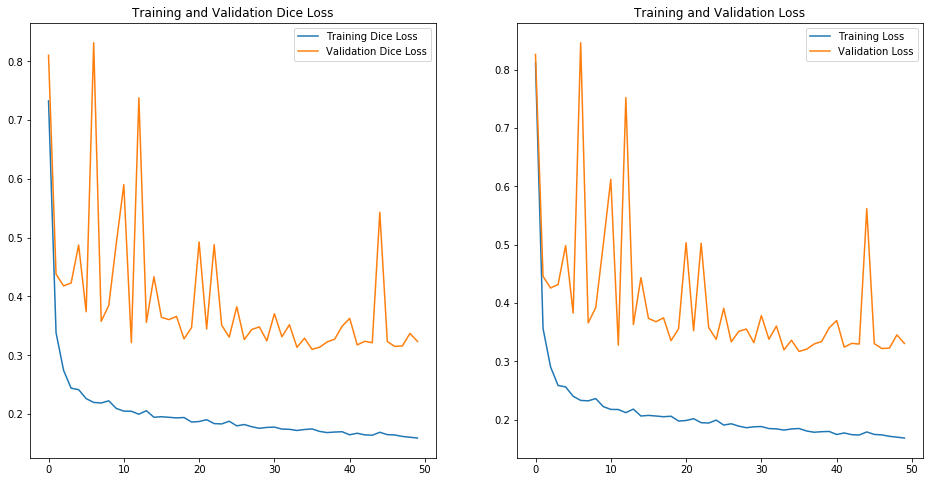

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Getting Prediction

In [0]:

flair_dir = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Testing/FLAIR/'
gt_dir = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Testing/GT/'

flair_name = 'patient_22_extracted_brain_normalised_slice_220.png'
gt_name = 'patient_22_gt_slice_220.png'


In [0]:
model_path_8 = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Models/3/model_unet_batch-16_Train_Test.hdf5'
model_path_16 = '/content/drive/My Drive/Colab Notebooks/Neural Networks Project/Data 2/Models/3/model_unet_batch-8_Train_Test.hdf5'



model_8 = models.load_model(model_path_8, custom_objects={'bce_dice_loss': bce_dice_loss,'dice_loss': dice_loss})

W0807 17:30:57.815639 140066114365312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 17:30:57.822259 140066114365312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0807 17:30:57.827886 140066114365312 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [0]:
img_width, img_height = 256, 256

os.chdir(flair_dir)
raw = image.load_img(flair_dir+flair_name, target_size=(img_width, img_height), grayscale = True, color_mode = 'grayscale')
raw = image.img_to_array(raw)
raw= np.expand_dims(raw, axis=0)
raw = np.vstack([raw])

os.chdir(gt_dir)
gt = image.load_img(gt_dir+gt_name, target_size=(img_width, img_height), grayscale = True, color_mode = 'grayscale')


pred = model_8.predict(raw)
pred = pred.reshape(256,256)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Text(0.5, 1.0, 'Prediction')

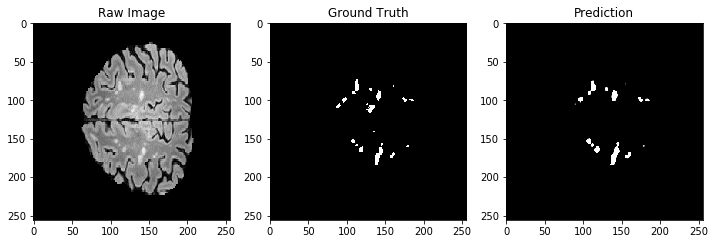

In [0]:
raw = image.load_img(flair_dir+flair_name, target_size=(img_width, img_height), grayscale = True, color_mode = 'grayscale')

plt.subplot(131)
plt.imshow(raw, cmap='gray') # GROUNT TRUTH ON THE LEFT
plt.title('Raw Image')

plt.subplot(132)
plt.imshow(gt, cmap='gray') # GROUNT TRUTH ON THE LEFT
plt.title('Ground Truth')

plt.subplot(133)
plt.imshow(pred, cmap='gray') # PREFICTION ON THE RIGHT
plt.title('Prediction')
